In [10]:
import cv2
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [11]:
# load monkbrill jpg data
data = dict()
data['label'] = []
data['filename'] = []
data['data'] = []   

data_path = "monkbrill-jpg/"
for subdir in os.listdir(data_path):
    current_path = os.path.join(data_path, subdir)

    for file in os.listdir(current_path):
        im = cv2.imread(os.path.join(current_path, file), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (38, 48)) # (width, height)
        data['label'].append(subdir)
        data['filename'].append(file)
        data['data'].append(im)

In [12]:
# load monkbrill jpg augmented data if yet created
data_augmented = dict()
data_augmented['label'] = []
data_augmented['filename'] = []
data_augmented['data'] = []   

data_path = "monkbrill-jpg-augmented/"
for subdir in os.listdir(data_path):
    current_path = os.path.join(data_path, subdir)

    for file in os.listdir(current_path):
        im = cv2.imread(os.path.join(current_path, file), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (38, 48)) # (width, height)
        data_augmented['label'].append(subdir)
        data_augmented['filename'].append(file)
        data_augmented['data'].append(im)

In [13]:
# one-hot encode class labels
encoder = LabelBinarizer()
onehot_labels = encoder.fit_transform(data['label'])

# one-hot encode class labels
encoder = LabelBinarizer()
onehot_labels_augmented = encoder.fit_transform(data_augmented['label'])

In [14]:
# split in training and validation data and normalize
# X_train, X_val, y_train, y_val = train_test_split(data['data'], onehot_labels, test_size=0.2, random_state=0, shuffle=True)
# X_train = np.array(X_train) / 255.0
# y_train = np.array(y_train) 
# X_val = np.array(X_val) / 255.0
# y_val = np.array(y_val)

original_test_data =  np.array(data['data'])
onehot_labels = encoder.fit_transform(data['label'])


X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(data_augmented['data'], onehot_labels_augmented, test_size=0.2, random_state=0, shuffle=True)
X_train_aug = np.array(X_train_aug) / 255.0
y_train_aug = np.array(y_train_aug) 
X_val_aug = np.array(X_val_aug) / 255.0
y_val_aug = np.array(y_val_aug)


In [15]:
# Build LeNet model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(48, 38, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(27, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 38, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 15, 48)        38448     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 7, 48)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 10, 7, 48)         0         
                                                                 
 flatten_1 (Flatten)         (None, 3360)             

In [16]:
# Compile and train model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
if not os.path.exists('models'):
        os.makedirs('models')
model_filepath = 'models/LeNet_model.h5'
callback = ModelCheckpoint(filepath=model_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(X_train_aug, y_train_aug, epochs=10, validation_data = (X_val_aug, y_val_aug), callbacks = [callback], verbose=1)

Epoch 1/10
1250/1250 [==============================] - 53s 42ms/step - loss: 0.5904 - accuracy: 0.8159 - val_loss: 0.1735 - val_accuracy: 0.9416
Epoch 2/10
1250/1250 [==============================] - 53s 42ms/step - loss: 0.1777 - accuracy: 0.9407 - val_loss: 0.1165 - val_accuracy: 0.9628
Epoch 3/10
1250/1250 [==============================] - 52s 41ms/step - loss: 0.1113 - accuracy: 0.9619 - val_loss: 0.0776 - val_accuracy: 0.9746
Epoch 4/10
1250/1250 [==============================] - 52s 42ms/step - loss: 0.0761 - accuracy: 0.9745 - val_loss: 0.0779 - val_accuracy: 0.9779
Epoch 5/10
1250/1250 [==============================] - 52s 42ms/step - loss: 0.0596 - accuracy: 0.9815 - val_loss: 0.0635 - val_accuracy: 0.9804
Epoch 6/10
1250/1250 [==============================] - 53s 42ms/step - loss: 0.0524 - accuracy: 0.9827 - val_loss: 0.0568 - val_accuracy: 0.9834
Epoch 7/10
1250/1250 [==============================] - 54s 43ms/step - loss: 0.0429 - accuracy: 0.9863 - val_loss: 0.0540 -

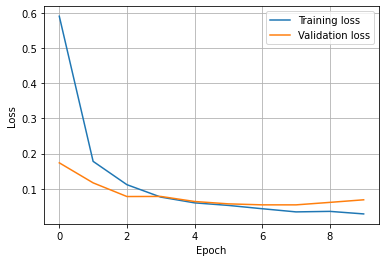

In [17]:
# Plot the loss
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


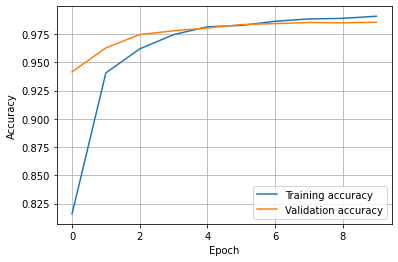

In [18]:
# Plot the accurcy
plt.plot(history.history['accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [19]:
score_original_data = model.evaluate(original_test_data, onehot_labels, verbose = 0)
print('Test loss on original data:', score_original_data [0]) 
print('Test accuracy on original data:', score_original_data [1])

Test loss: 0.11861389130353928
Test accuracy: 0.9996387958526611
